In [9]:
import numpy as np
import pandas as pd
from scipy import stats
from sklearn.linear_model import LinearRegression
import seaborn as sns
from matplotlib import pyplot as plt
plt.rcParams.update({'font.size': 18})
plt.rcParams['axes.linewidth'] = 2

In [6]:
def convert_gains(gain, bits_decimal = 8):
    '''
    Function to convert gain values from integer representation of multiples of 
    the ADC resolution to float
    '''
    resolution = 2**-8
    return -32+(gain-8192)*resolution if gain >=8192 else  gain*resolution

def get_plot_params(df):
    '''
    Extract median and std from shifts to create plot with shifts and 
    the respectives error bars
    '''
    filt_grouped = df.groupby('final_gain', as_index=False).agg(np.median)
    gains = filt_grouped['final_gain'].values
    median_shifts = filt_grouped['shift'].values
    std = df.groupby('final_gain').agg(np.std)['shift'].values
    return gains, median_shifts, std



def include_quartis(df):
    '''
    Include Q1 and Q3 values for each gain to remove outliers and 
    execute data cleaning
    '''
    q1 = df.groupby('gain', as_index=False).quantile(0.25)
    q1['shift_q1'] = q1['shift']
    q1 = q1.drop('shift', axis=1)
    df = pd.merge(df, q1[['gain', 'shift_q1']], on='gain')
    q3 = df.groupby('gain', as_index=False).quantile(0.75)
    q3['shift_q3'] = q3['shift']
    q3 = q3.drop('shift', axis=1)
    df = pd.merge(df, q3[['gain', 'shift_q3']], on='gain')
    df['diq'] = df['shift_q3'] - df['shift_q1']
    df['upper'] = df['shift_q3'] + 1.5*df['diq']
    df['bottom'] = df['shift_q1'] - 1.5*df['diq']
    return df

In [11]:
df = pd.read_csv('../data/shift/data.csv', index_col=False)
df.head()

,gain,batch,omega,omega_ref
0,10394,0,80519.193286,80058.792346
1,10601,0,79652.248500,81345.428762
2,10824,0,80586.942211,81274.120058
3,11065,0,80608.286129,80792.427812
4,11332,0,80649.449494,80750.302388


/tmp/ipykernel_11231/3086217191.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['shift'] = df['omega'] - df['omega_ref']


[-0.00051795]


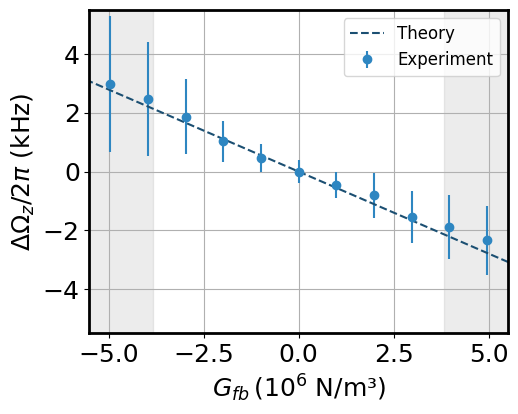

In [13]:
def process_df(df):
    '''
    Function to process df, remove unused gains, 
    filter via interquatil interval, apply conversion to gains
    '''
    df = df[~df['gain'].isin([7388, 8000, 8384, 9000])]
    df['shift'] = df['omega'] - df['omega_ref']
    df = include_quartis(df)
    df = df[(df['shift']>df['bottom'])&(df['shift']<df['upper'])]
    df['gain'] = df['gain'].apply(convert_gains)
    df['final_gain'] = 11.27*3.03e-15*np.power(-11*1.504e4*df['gain'].values,3)
    df = df.sort_values(by=['final_gain'])

    filt_df = df[(df['final_gain']>-2e6)&(df['final_gain']<2e6)]
    out_of_perturbation = df[(df['final_gain']<-2e6)|(df['final_gain']>2e6)] 
    filt_df = df.copy()        
    gains, median_shifts, std = get_plot_params(filt_df)
    gains_pert, median_shifts_pert, std_pert = get_plot_params(out_of_perturbation)

    X = filt_df['final_gain'].values.reshape((-1,1))
    y = filt_df['shift'].values
    model = LinearRegression().fit(X, y)
    r_sq = model.score(X, y)
    print(model.coef_)
    gain_linspace = np.linspace(1.4*df['final_gain'].values.min(), 
                        1.4*df['final_gain'].values.max(), 100)   
    y = model.coef_*gain_linspace + model.intercept_
    delta_f = -0.000558736548199816
    [-0.00051795]

    colors = ['#2E86C1', '#85C1E9', '#1B4F72']
    fig = plt.figure(figsize=(5.4, 4.2))
    plt.plot(gain_linspace/1e6, gain_linspace*delta_f/1e3, linestyle='--', color=colors[2])
    plt.ylim([-5.5, 5.5])
    plt.xlim([-5.5, 5.5])
    plt.errorbar(gains[::5]/1e6, median_shifts[::5]/1e3, yerr=std[::5]/1e3, fmt='o', color=colors[0])   
    plt.grid()
    plt.xlabel(r'$G_{fb} \,(10^6$ N/m³)')
    plt.ylabel(r'$\Delta \Omega_z/2\pi$ (kHz)')
    plt.legend(['Theory', 'Experiment'], fontsize=12)
    plt.fill_between([-5.5, -3.83], [6e3, 6e3], [-6e3, -6e3], color='gray', alpha=0.15)
    plt.fill_between([3.83, 5.5], [6e3, 6e3], [-6e3, -6e3], color='gray', alpha=0.15)
    plt.savefig('../plots/shift.pdf', bbox_inches='tight')
    plt.show()
    
process_df(df)

In [8]:
df = pd.read_csv('full_data.csv', index_col=False)
df = df[~df['gain'].isin([7388, 8000, 8384, 9000])]
df['shift'] = df['omega'] - df['omega_ref']

df = include_quartis(df)
print('Total length of dataset - {}'.format(len(df)))
df = df[(df['shift']>df['bottom'])&(df['shift']<df['upper'])]
print('Total length of FILTERED dataset - {}'.format(len(df)))
df['gain'] = df['gain'].apply(convert_gains)
# remove gains that are not in the step and were taken in the first measure
df['final_gain'] = 11.27*3.03e-15*np.power(-11*1.504e4*df['gain'].values,3)
df = df.sort_values(by=['final_gain'])

filt_df = df[(df['final_gain']>-2e6)&(df['final_gain']<2e6)]
out_of_perturbation = df[(df['final_gain']<-2e6)|(df['final_gain']>2e6)] 
filt_df = df.copy()        
gains, median_shifts, std = get_plot_params(filt_df)

gains_pert, median_shifts_pert, std_pert = get_plot_params(out_of_perturbation)

X = filt_df['final_gain'].values.reshape((-1,1))
y = filt_df['shift'].values
model = LinearRegression().fit(X, y)
r_sq = model.score(X, y)
print(model.coef_)
gain_linspace = np.linspace(1.4*df['final_gain'].values.min(), 
                        1.4*df['final_gain'].values.max(), 100)   
y = model.coef_*gain_linspace + model.intercept_
delta_f = -0.000558736548199816

fig = plt.figure(figsize=(5.4, 4.2))

#plt.scatter(out_of_perturbation['final_gain'], out_of_perturbation['shift'], s=10, marker='o', color='black')
#    plt.plot(gain_linspace, y)    
plt.plot(gain_linspace/1e6, gain_linspace*delta_f, linestyle='--', color='r')
plt.ylim([-5.5e3, 5.5e3])
plt.xlim([-5.5, 5.5])
plt.errorbar(gains/1e6, median_shifts, yerr=std, fmt='o')   
plt.grid()
plt.xlabel(r'$G_{fb} \,(10^6$ N/m²)')
plt.ylabel(r'$\Delta \Omega_z/2\pi$ (Hz)')
plt.legend(['Theory', 'Experiment'], fontsize=12)
plt.fill_between([-5.5, -3.83/10], [6e3, 6e3], [-6e3, -6e3], color='gray', alpha=0.15)
plt.fill_between([3.83/10, 5.5], [6e3, 6e3], [-6e3, -6e3], color='gray', alpha=0.15)
plt.show()

FileNotFoundError: [Errno 2] No such file or directory: 'full_data.csv'

In [ ]:
rho=2200
R = 150e-9/2
m = rho*np.pi*4*R**3/3
kb = 1.38e-23
omega = 2*np.pi*8.5e4
T = 273+22
gamma = 13578.7501
m*m*gamma*omega**3/(2*kb*T)/1e6

In [ ]:
df = pd.read_csv('full_data.csv', index_col=False)
df['shift'] = df['omega'] - df['omega_ref']

df = include_quartis(df)
print('Total length of dataset - {}'.format(len(df)))
print(df['gain'].unique())
df = df[(df['shift']>df['bottom'])&(df['shift']<df['upper'])]
print('Total length of FILTERED dataset - {}'.format(len(df)))
df['final_gain'] = df['gain'].apply(convert_gains)
# remove gains that are not in the step and were taken in the first measure
df['final_gain'] = 11.27*3.03e-15*np.power(-11*1.504e4*df['final_gain'].values,3)


In [ ]:
df['gain'].unique()

In [ ]:
stats.shapiro(df[df['gain']==2780]['shift'].values[::5])

In [4]:
def gaussian_plot_params(df, gain):
    sub_df = df[df['gain']==gain]
    mean = sub_df['shift'].values.mean()
    std = sub_df['shift'].values.std()
    final_gain = sub_df['final_gain'].values[0]
    return mean, std, final_gain

In [178]:
len(df['batch'].unique())

199

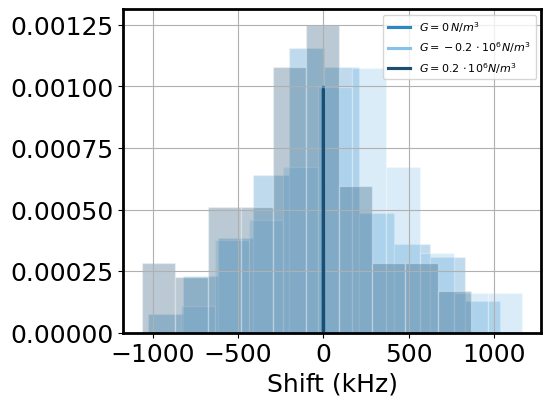

In [242]:
legends = []
#ax, fig = plt.Figure(figsize=(100.4,4.2))
plt.rcParams['figure.figsize'] = [5.4,4.2]
plt.rcParams.update({'font.size': 18})
plt.rcParams['axes.linewidth'] = 2
colors = ['#2E86C1', '#85C1E9', '#1B4F72']
for i, gain in enumerate([0, 2780, 13604]):
    mu, std, final_gain = gaussian_plot_params(df, gain)
    ##sigma = math.sqrt(variance)
    x = np.linspace(mu - 3*std, mu + 3*std, 100)
    y_bin, bins = np.histogram(df[df['gain']==gain]['shift'].values, bins=6, density=True)
#    plt.hist(df[df['gain']==gain]['shift'].values, density=True, bins=6, , color=colors[i], edgecolor='white')
    plt.plot(x/1e3, stats.norm.pdf(x, mu, std), linewidth=2.25, color=colors[i])
    if gain == 0:
        legends.append(r'$G={}\,N/m^3$ '.format(0))
    else:
        legends.append(r'$G={}\,\cdot 10^6 N/m^3$ '.format(np.round(final_gain/1e6, 2)))

for i, gain in enumerate([0, 2780, 13604]):
    mu, std, final_gain = gaussian_plot_params(df, gain)
    ##sigma = math.sqrt(variance)
    x = np.linspace(mu - 3*std, mu + 3*std, 100)
    #y_bin, bins = np.histogram(df[df['gain']==gain]['shift'].values, bins=6, density=True)
    plt.hist(df[df['gain']==gain]['shift'].values, density=True, bins=10, alpha = 0.3, color=colors[i], edgecolor='white')
    #plt.scatter((bins[:-1]+np.diff(bins)[0]/2)/1e3, y_bin, color=colors[i])

plt.grid()
plt.xlabel('Shift (kHz)')
plt.legend(legends, loc='upper right', fontsize=8)
plt.show()

In [187]:
mean

NameError: name 'mean' is not defined